<a href="https://colab.research.google.com/github/takohaller/smarturbanheatmap/blob/main/Smart_Urban_Heat_Map_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Example of IoT Programming for the Smart City

This example shows how temperature and humidity data from weather stations in the Bern region can be queried and visualised using simple Python code. This example was developed as part of the __[Smart Urban Heat Map Bern](https://smart-urban-heat-map.ch/)__ project.

It uses a **Web-API** that was defined by [MeteoTest](https://meteotest.ch/en/company/about-us), a Swiss private company that develops and sells data driven services and products in the areas of weather, climate and the environment. It is simple to use, but doesn't conform to any standards like [SensorThings](https://www.ogc.org/standard/sensorthings/) defined by the [Open Geospatial Consortium](https://www.ogc.org/).

API documentation: https://meteotest.github.io/urban-heat-API-docs/Swagger/.




## Part 1 - Loading and Displaying Current Data

### Step 1: Importing the required Python libraries

In [ ]:
import io # for working with streams (like strings)
import requests # for making standard HTTP requests
import pandas as pd # for storing and manipulating data
import geopandas as gpd # for storing and manipulating geographic data
import folium # for creating maps
import branca # for using colorscales in Folium
import json # for data handling

### Step 2: Query list of all weather stations

In [ ]:
# Define the URL
url = "https://smart-urban-heat-map.ch/api/1.0/stations"

# Make the GET request
response = requests.get(url)

# Display the result
print(response.text)

Reformatting for better readability:

In [ ]:
print(json.dumps(response.json(), indent=2))

Loading the data as GeoPandas dataframe improves the readability of the data in a single step:

In [ ]:
stations = gpd.read_file(response.text)

# Display stations DataFrame
stations

### Step 3: Visualisation on a map

To start with, here is the code to display a map. It is automatically centered according to the average longitude and latitude of the weather stations.


In [ ]:
# Create a base map
map1 = folium.Map(location=[stations.geometry.y.mean(), stations.geometry.x.mean()], zoom_start=10)

# Display map
map1

Second, we display the location of the weather stations, but without weather data measurements:

In [ ]:
# Create a base map
map2 = folium.Map(location=[stations.geometry.y.mean(), stations.geometry.x.mean()], zoom_start=10)

# Iterate through each station in the GeoPandas DataFrame
for idx, station in stations.iterrows():
    # Create a circle marker for each station and add it to the map
    folium.CircleMarker(
        # Location of the marker in lat and lon
        location=(station.geometry.y, station.geometry.x),
        # Styling the marker
        radius=5,
        color="black",  # Border color
        weight=0.5,  # Border width
        fill=True,
        fill_color="black",
        fill_opacity=1, # 1 means 100% opaque
        # Add a tooltip with station name
        tooltip=f"{station['name']}",
    # Add the marker to the map
    ).add_to(map2)

map2

And finally, we can give the weather stations a colour depending on the current temperature and also add tooltips:


In [ ]:
# Create a base map
map3 = folium.Map(location=[stations.geometry.y.mean(), stations.geometry.x.mean()], zoom_start=13)#, tiles="CartoDB positron")

# Most popular colormaps are sequential, meaning that they have a start and end color
# Define a function to reverse a colormap
def reversed_colormap(existing):
    return branca.colormap.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax
    )

def formatToolTip(stationName, temperature, humidity):
    return f"{stationName}: {temperature:.2f}°C, {humidity:.2f}%"

def formatToolTip2(stationName, temperature, humidity):
    return f"<h4>{stationName}</h4>Temperature: {temperature:.2f}°C<br/>Humidity: {humidity:.2f}%"


# Create a colormap for a temperature range of 10-37°C
# Choose an appropriate colormap (Spectral_11) and reverse it so that it goes from blue (cold) to red (hot)
colormap = reversed_colormap(branca.colormap.linear.Spectral_11)
# Scale the colormap to the temperature range and discretize it into 9 steps for better visibility
colormap = colormap.scale(0, 20).to_step(9)
# Add a caption to the colormap
colormap.caption = "Temperature (°C)"
# Add colormap to the map
colormap.add_to(map3)

# Iterate through each station in the GeoPandas DataFrame
for idx, station in stations.iterrows():
    # Create a circle marker for each station and add it to the map
    folium.CircleMarker(
        # Location of the marker in lon and lat
        location=(station.geometry.y, station.geometry.x),
        # Styling the marker
        radius=5,
        color="black",  # Border color
        weight=0.5,  # Border width
        fill=True,
        # Set the fill color to the colormap value corresponding to the station temperature
        fill_color=colormap(station['temperature']),
        fill_opacity=1, # 1 means 100% opaque
        # Add a tooltip with station name and temperature
        tooltip=formatToolTip2(station['name'], station['temperature'], station['relativeHumidity'])
    # Add the marker to the map
    ).add_to(map3)

# Display map
map3

## Part 2 - Display Measurement Data over Time

### Step 1: Query data for a specific weather station

e.g., at the Government Plaza ("Bundesplatz" in German):

In [ ]:
# Based on a station name, get the respective stationId from the DataFrame
stationId = stations[stations["name"] == "Bundesplatz"].stationId.values[0]
# Define the URL including the stationId argument
url = f"https://smart-urban-heat-map.ch/api/1.0/timeseries?stationId={stationId}"

# Define the headers to request CSV data as a python dictionary
headers = {
    "Accept": "text/csv"
}

# Make the GET request with the headers
response = requests.get(url, headers=headers)

# Get the timeseries into a data frame
timeseries = pd.read_csv(io.StringIO(response.text), delimiter=";")

timeseries

### Step 2: Show data in a graph

By default, the data from the last 48 hours is returned.

In [ ]:
# Use the DataFrame plot function to plot the temperature time series as a line plot with markers
ax = timeseries.plot(x='dateObserved', y='temperature', figsize=(10,6), marker=None, linestyle='-')
# The ax object is a matplotlib axis object which we can use to further customize the plot

# Add a title
ax.set_title('Bundesplatz')

# Add labels for the x and y axes
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')

# Shift every second x-label for better readability
for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 == 0:  # Check if it's an odd tick
        label.set_y(-0.04)

### Step 3: Display data from multiple stations in a specific time period
First, we set the time period:

In [ ]:
startTime = "2024-04-28T00:00:00Z" # 28.09.23 00:00 ; Z means UTC time
endTime = "2024-04-30T23:00:00Z" # 31.09.23 23:00

Now we can query and display the data:

In [ ]:
import matplotlib.pyplot as plt

# Define function to read the data for a specific station and a specific time range.
# Returns the data as a Pandas dataframe
def getData(stationName, startTime, endTime):
    #Define the headers to request CSV data as a python dictionary
    headers = {
        "Accept": "text/csv"
    }

    # Read the data
    stationId = stations[stations["name"] == stationName].stationId.values[0]
    # Define the URL including the stationId argument
    url = f"https://smart-urban-heat-map.ch/api/1.0/timeseries?stationId={stationId}&timeFrom={startTime}&timeTo={endTime}"

    # Make the GET request with the headers
    response = requests.get(url, headers=headers)
    return pd.read_csv(io.StringIO(response.text), delimiter=";")

# Read the data for the 3 stations:
stationName1 = "Bundesplatz"
stationName2 = "Marktplatz Lyss"
stationName3 = "Ittigen Papiermühle Kreisel"
timeseries1 = getData(stationName1, startTime, endTime)
timeseries2 = getData(stationName2, startTime, endTime)
timeseries3 = getData(stationName3, startTime, endTime)

# Now plot the data
plt.figure(figsize=(10, 6))


# Use the DataFrame plot function to plot the temperature time series as a line plot with markers
timeseries1.plot(x='dateObserved', y='temperature', label=stationName1, marker=None, color='blue', linestyle='-', ax=plt.gca())
timeseries2.plot(x='dateObserved', y='temperature', label=stationName2, marker=None, color='green', linestyle='-', ax=plt.gca())
timeseries3.plot(x='dateObserved', y='temperature', label=stationName3, marker=None, color='red', linestyle='-', ax=plt.gca())

plt.title('Temperature Curve')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')





# Exercises

## Exercise 1

Query the relative humidity data for the week from April 1 to April 7 for the following weather stations
* Sigriswil
* Westside Center
* Elfenau

Make sure to use the correct time zone of Switzerland; also Switzerland changed to Daylight Saving Time on March 31, 2024.

Display the data as graph.


In [ ]:
# Your code goes here




**Expected Result**: If you did everything correctly, the following graph should be displayed:
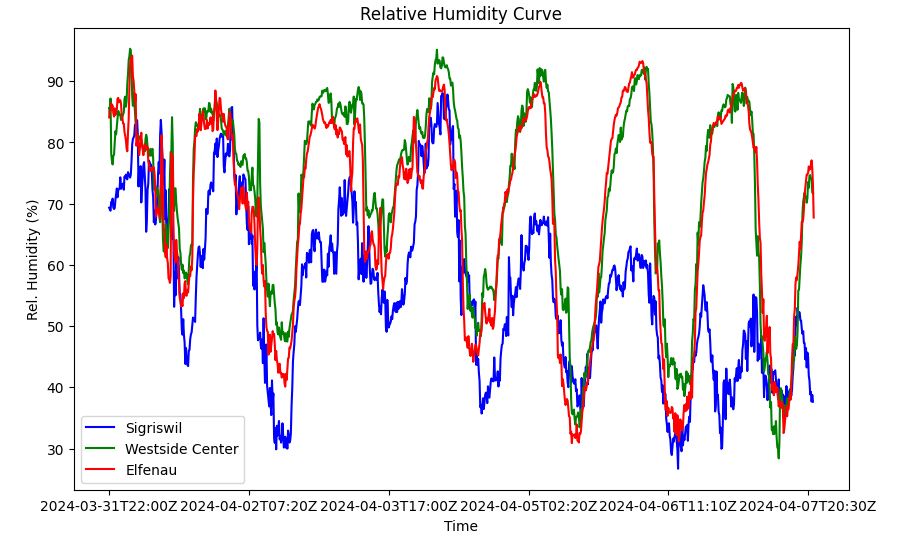

## Exercise 2
What was the average temperature in Sigriswil during that week?

Round the results to 2 digits.

In [ ]:
# Your code goes here



**Expected Result**: The average temperature was *13.07 °C*.